In [24]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard, ReduceLROnPlateau

from glob import glob
from tqdm import tqdm

from utils import *
from unet_model import *
from model1 import *
from metries import *
from pathlib import Path

In [25]:
INPUT_DIR = '/data/zlpppp/ct'
INPUT_DIR = result = Path(INPUT_DIR).as_posix()
SEGMENTATION_DIR = os.path.join(INPUT_DIR, "segmentation")
SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test")
SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")
SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation")
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask")
SEGMENTATION_DILATE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "dilate")
SEGMENTATION_SOURCE_DIR = os.path.join(INPUT_DIR, \
                                       "pulmonary-chest-xray-abnormalities")
SEGMENTATION_TEST_IMAGE_DIR = os.path.join(SEGMENTATION_TEST_DIR, 'image')
SEGMENTATION_TEST_MASK_DIR = os.path.join(SEGMENTATION_TEST_DIR, 'mask')
SEGMENTATION_TEST_DILATE_DIR = os.path.join(SEGMENTATION_TEST_DIR, 'dilate')

In [26]:
train_files = sorted(glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.png")))
test_image_files = sorted(glob(os.path.join(SEGMENTATION_TEST_IMAGE_DIR, "*.png")))
test_dilate_files = sorted(glob(os.path.join(SEGMENTATION_TEST_DILATE_DIR, "*.png")))
mask_files = sorted(glob(os.path.join(SEGMENTATION_MASK_DIR, "*.png")))
dilate_files = sorted(glob(os.path.join(SEGMENTATION_DILATE_DIR, "*.png")))

test_files = []
for i in range(len(test_image_files)):
    test_files.append(test_image_files[i])
    test_files.append(test_dilate_files[i])

(len(train_files), \
 len(test_image_files), \
 len(test_dilate_files), 
 len(mask_files), \
 len(dilate_files), len(test_files))

(604, 100, 100, 604, 604, 200)

In [27]:
print(sorted(test_image_files)[0:5])
print(sorted(test_dilate_files)[0:5])

['/data/zlpppp/ct/segmentation/test/image/CHNCXR_0002_0.png', '/data/zlpppp/ct/segmentation/test/image/CHNCXR_0005_0.png', '/data/zlpppp/ct/segmentation/test/image/CHNCXR_0015_0.png', '/data/zlpppp/ct/segmentation/test/image/CHNCXR_0020_0.png', '/data/zlpppp/ct/segmentation/test/image/CHNCXR_0029_0.png']
['/data/zlpppp/ct/segmentation/test/dilate/CHNCXR_0002_0_dilate.png', '/data/zlpppp/ct/segmentation/test/dilate/CHNCXR_0005_0_dilate.png', '/data/zlpppp/ct/segmentation/test/dilate/CHNCXR_0015_0_dilate.png', '/data/zlpppp/ct/segmentation/test/dilate/CHNCXR_0020_0_dilate.png', '/data/zlpppp/ct/segmentation/test/dilate/CHNCXR_0029_0_dilate.png']


In [28]:
def test_generator(batch_size, test_path, image_folder, mask_folder,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="dilate",
        save_to_dir=None,
        target_size=(256,256)):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()

    image_generator = image_datagen.flow_from_directory(
        test_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        shuffle = False)

    mask_generator = mask_datagen.flow_from_directory(
        test_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        shuffle = False)

    test_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in test_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

        
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [29]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
# def test_load_image(test_file, target_size=(256,256)):
#     img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
#     img = img / 255
#     img = cv2.resize(img, target_size)
#     img = np.reshape(img, img.shape + (1,))
#     img = np.reshape(img,(1,) + img.shape)
#     return img

# def test_generator2(test_image_files, test_mask_files, target_size=(512,512)):
#     for (test_image_file, test_mask_file) in zip(tuple(test_image_files), tuple(test_mask_files)):
#         yield (test_load_image(test_image_file, target_size), test_load_image(test_mask_file, target_size))
        
# def save_result(save_path, npyfile, test_files):
#     for i, item in enumerate(npyfile):
#         result_file = test_files[i]
#         img = (item[:, :, 0] * 255.).astype(np.uint8)

#         filename, fileext = os.path.splitext(os.path.basename(result_file))

#         result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

#         cv2.imwrite(result_file, img)

In [30]:
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

In [33]:
#test_gen = test_generator(test_files, target_size=(512,512))
save_path = '/output'
BATCH_SIZE = 1
# print(glob(os.path.join(SEGMENTATION_TEST_DILATE_DIR, '*.png')))
# test_gen = test_generator(BATCH_SIZE, SEGMENTATION_TEST_DIR,SEGMENTATION_TEST_IMAGE_DIR, SEGMENTATION_TEST_DILATE_DIR,
#                                        target_size=(512,512))
test_gen = test_generator(BATCH_SIZE, SEGMENTATION_TEST_DIR, 'image', 'dilate', target_size=(512,512))
# test_gen = test_generator2(train_files, dilate_files, target_size=(512,512))

# model = load_model('/model/zlpppp/BDC_Unet/unet_lung_seg_BDC_UNet_.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})
model = load_model('/model/zlpppp/unet_trial/unet_lung_seg_UNet_trial4.hdf5', custom_objects={'Combo_loss':Combo_loss, 'dice_coef':dice_coef, 'IOU':IOU, 'precision':precision,
                                                                                                  'recall':recall,
                                                                                                  'f1':f1,
                                                                                                  'auc':auc})
# model = load_model('/model/zlpppp/unet_trial/unet_lung_seg_UNet_trial4.hdf5', custom_objects={'dice_coef_loss':dice_coef_loss, 'dice_coef':dice_coef, 'IOU':IOU, 'precision':precision,
#                                                                                                   'recall':recall,
#                                                                                                   'f1':f1,
#                                                                                                   'auc':auc})
results = model.predict_generator(test_gen, len(test_image_files), verbose=1)
print(results.shape)
print(type(result))
save_result(save_path, results, test_image_files)
# test_gen2 = test_generator1(BATCH_SIZE, SEGMENTATION_TRAIN_DIR, 'image', 'dilate', target_size=(512,512))
model.evaluate_generator(test_gen, len(test_image_files), max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
100/100 [==============================] - 3s 33ms/step
(100, 512, 512, 1)
<class 'str'>
100/100 [==============================] - 5s 50ms/step


[0.1871284255385399,
 0.9243314677476883,
 0.9669479751586914,
 0.9743821299076081,
 0.9767358684539795,
 0.9144829106330872,
 0.9435007870197296,
 0.9924002277851105]

(512, 512, 3)


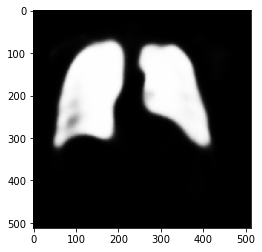

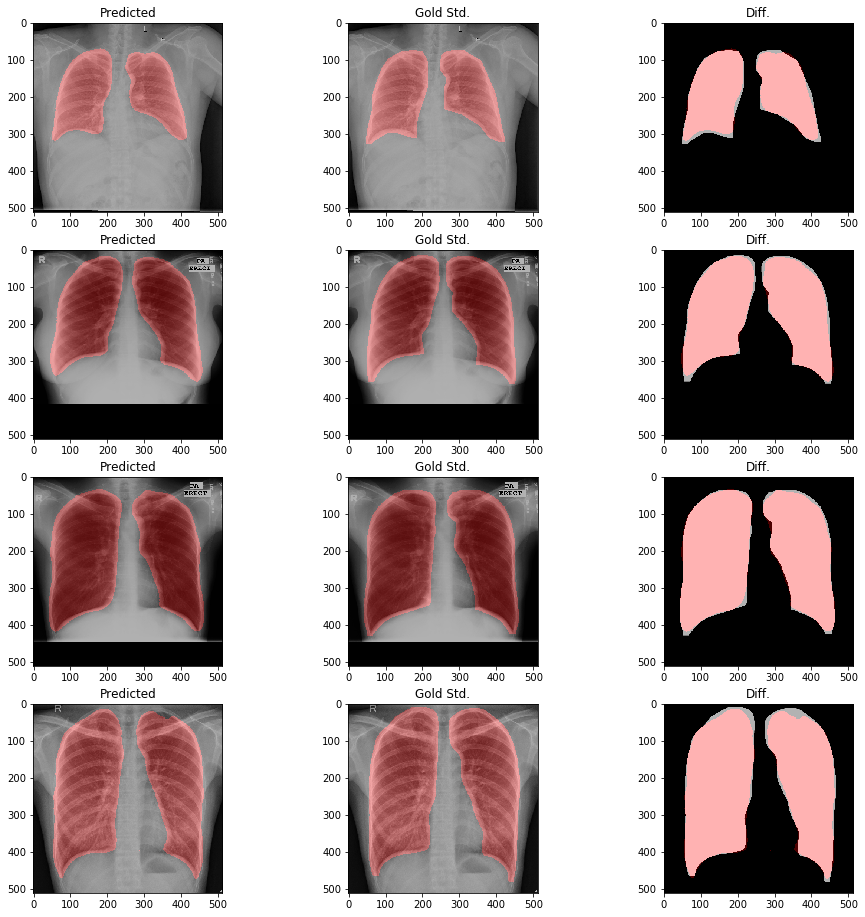

In [35]:
image = cv2.imread("/data/zlpppp/ct/segmentation/train/image/CHNCXR_0008_0.png")
# plt.imshow(image)
predict_image = cv2.imread("/output/CHNCXR_0008_0_predict.png")
print(predict_image.shape)
GrayImage=cv2.cvtColor(predict_image,cv2.COLOR_BGR2GRAY)
_,thresh=cv2.threshold(GrayImage,127,255,cv2.THRESH_BINARY)
# plt.imshow(thresh,'gray')
plt.imshow(predict_image, 'gray')
mask_image = cv2.imread("/data/zlpppp/ct/segmentation/train/dilate/CHNCXR_0008_0.png")

fig, axs = plt.subplots(4, 3, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/data/zlpppp/ct/segmentation/test/image/MCUCXR_0100_0.png")
predict_image = cv2.imread("/output/MCUCXR_0100_0_predict.png")
mask_image = cv2.imread("/data/zlpppp/ct/segmentation/test/dilate/MCUCXR_0100_0_dilate.png")

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/data/zlpppp/ct/segmentation/test/image/MCUCXR_0104_1.png")
predict_image = cv2.imread("/output/MCUCXR_0104_1_predict.png")
mask_image = cv2.imread("/data/zlpppp/ct/segmentation/test/dilate/MCUCXR_0104_1_dilate.png")

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/data/zlpppp/ct/segmentation/test/image/CHNCXR_0331_1.png")
predict_image = cv2.imread("/output/CHNCXR_0331_1_predict.png")
mask_image = cv2.imread("/data/zlpppp/ct/segmentation/test/dilate/CHNCXR_0331_1_dilate.png")

axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))